In [7]:
import numpy as np
from networkx.generators.community import LFR_benchmark_graph
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
import networkx as nx
import louvain
import igraph
import leidenalg
from cdlib import algorithms
from random import seed

import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("darkgrid")

**Functions and Classes**

Creating function to generate networks based on LFR benchmarks.

Due to restrictions of the "LFR_benchmark_graph", we explicitly used min_degree=20 and max_degree=50

In [8]:
def genrate_lfr_graph(size,mu,tau1,tau2,seed):
    params = {"n":size, "tau1":tau1, "tau2":tau2, "min_degree":20, "max_degree":50,"mu":mu}

    try:
      G = LFR_benchmark_graph(n=params["n"], tau1=params["tau1"],tau2= params["tau2"], mu=params["mu"], 
                          min_degree=params["min_degree"],
                          max_degree=params["max_degree"],
                          max_iters=5000, seed = seed,
                          )
      print("Generation Completed")
      return G  
    except:
      print("There was an error in generating the graph")



In order to use "leidenalg" and "leiden", we need to generate igraphs.

This function gets the regular network and returns the igraph.

In [9]:
def generate_igraph(G):
    G_nx_edges = list(G.edges)
    G_nx_nodes = list(G.nodes)
    G_ig = igraph.Graph(directed=False)
    G_ig.add_vertices(G_nx_nodes)
    G_ig.add_edges(G_nx_edges)
    return G_ig


Creating a class with different methods for each algorithm (leiden, CNM, louvain, eigenvector and spin-glass)

In [10]:
class Modulairty_Algorithms:

    def __init__(self, G):
        self.G = G
        self.G_ig = generate_igraph(G)


    def leiden(self):
        return leidenalg.find_partition(self.G_ig, leidenalg.ModularityVertexPartition)

    def CNM(self):
        return sorted(greedy_modularity_communities(self.G), key=len, reverse=True)

    def louvain(self):
        return louvain.find_partition(self.G_ig, louvain.ModularityVertexPartition)

    def eigenvector(self):
        return algorithms.eigenvector(self.G).communities

    def spinglass(self):
        return algorithms.spinglass(self.G).communities

        

**Performing Algorithms on Generated Graphs**

For different values of mu, tau1, tau2 and size, we first generate the graph.

Then we run the algorithms for each of the graphs and calculate the modularity and the time spent on running the algorithms. 

This is important to note that due to time consuming of "spinglass" and "CNM" they are not performed on large graphs (n>=5000)

Another crucial fact is that each graph is generated for 5 times with different seeds to reduce the randomness. 

In [11]:
min_mu = 0.3
max_mu=0.8
mu_list = list(np.arange(min_mu,max_mu,0.1))

min_tau1 = 2
max_tau1 = 4
tau1_list = list(range(min_tau1,max_tau1,1))

min_tau2 = 1.1
max_tau2 = 3
tau2_list = list(np.arange(min_tau2,max_tau2,1))

n_range = [250,500,1000,2000,5000,10000,15000,20000,30000,40000]

seed_list=list(range(10,60,10))

method_list = ['leiden','CNM','louvain','eigenvector','spinglass']

result = list()

count = 0 

for mu in mu_list:
  for tau1 in tau1_list:
    for tau2 in tau2_list:
      for n in n_range:
          for seed in seed_list:

            try:

                G = genrate_lfr_graph(size=n,mu=mu,tau1=tau1,tau2=tau2,seed=seed)
                mod_instance = Modulairty_Algorithms(G)

                for meth in method_list:

                    if meth in ['spinglass','CNM']  and n>=5000:
                        continue

                    begin_t = time.process_time()

                    method = getattr(Modulairty_Algorithms, meth)
                    community = method(mod_instance)
                    mod_result = modularity(G,community)

                    duration = time.process_time() - begin_t

                    result.append([meth,n,mu,tau1,tau2,mod_result,duration])

                    count+=1

                    print(count,[meth,n,mu,tau1,tau2,mod_result,duration])
            except:
                continue


df = pd.DataFrame(columns = ["Algorithm","n", "mu", "tau1", "tau2","modularity","Time(S)"], data = result)


**Data Analysis**

In [13]:
df_gb = df.groupby(['Algorithm','n','mu','tau1','tau2']).agg({'modularity':'mean','Time(S)': 'mean'} ).reset_index()
df_gb_smallN = df_gb[df_gb['n']<5000]
df_gb_largeN = df_gb[df_gb['n']>=5000]

*Modularity and Time Grouped by Different Algorithms*

In [14]:
df_gb_smallN.groupby(['Algorithm']).agg({'modularity':'mean','Time(S)': 'mean'} ).reset_index()

,Algorithm,modularity,Time(S)
0,CNM,0.201940,10.983640
1,eigenvector,0.146555,0.432573
2,leiden,0.245240,0.059919
3,louvain,0.242710,0.099529
4,spinglass,0.252836,35.546984


In [15]:
df_gb_largeN.groupby(['Algorithm']).agg({'modularity':'mean','Time(S)': 'mean'} ).reset_index()

,Algorithm,modularity,Time(S)
0,eigenvector,0.138999,15.617179
1,leiden,0.283538,2.472377
2,louvain,0.281588,4.668044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


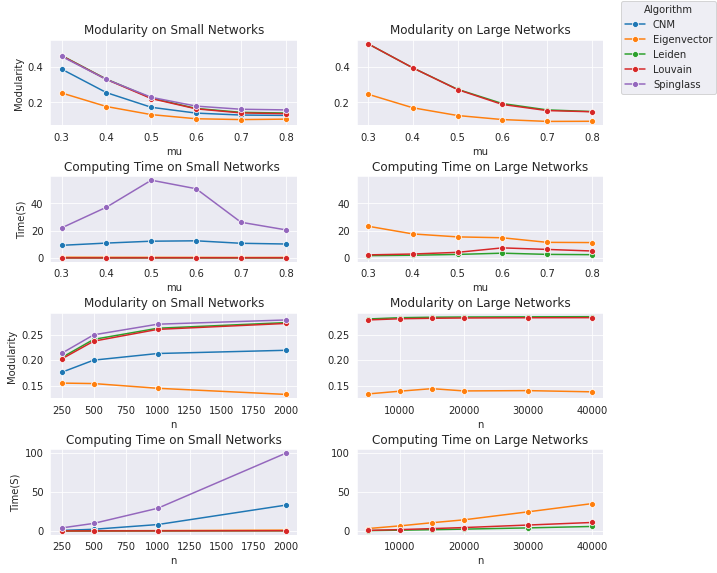

In [27]:
unique = df_gb_smallN["Algorithm"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

fig=plt.figure(figsize=(10,8))
ax1 = plt.subplot(421)
ax2 = plt.subplot(422, sharex = ax1 , sharey= ax1)
ax3 = plt.subplot(423)
ax4 = plt.subplot(424, sharex = ax3 , sharey = ax3)
ax5 = plt.subplot(425)
ax6 = plt.subplot(426, sharey= ax5)
ax7 = plt.subplot(427)
ax8 = plt.subplot(428, sharey = ax7)

fig.tight_layout(pad=3.0)
plt.subplots_adjust(right=0.85)


l1 = sns.lineplot( x=df_gb_smallN["mu"],y=df_gb_smallN["modularity"],hue=df_gb_smallN["Algorithm"],ci=None, marker="o", ax=ax1, palette=palette , legend=False)
l1.set(ylabel='Modularity',title = 'Modularity on Small Networks')


l2 = sns.lineplot( x=df_gb_largeN["mu"],y=df_gb_largeN["modularity"],hue=df_gb_largeN["Algorithm"],ci=None, marker="o", ax=ax2, palette=palette, legend=False)
l2.set(ylabel=None,title = 'Modularity on Large Networks')

l3 = sns.lineplot( x=df_gb_smallN["mu"],y=df_gb_smallN["Time(S)"],hue=df_gb_smallN["Algorithm"],ci=None, marker="o", ax=ax3, palette=palette, legend=False)
l3.set(title = 'Computing Time on Small Networks ')

l4 = sns.lineplot( x=df_gb_largeN["mu"],y=df_gb_largeN["Time(S)"],hue=df_gb_largeN["Algorithm"],ci=None, marker="o", ax=ax4, palette=palette, legend=False)
l4.set(ylabel=None,title = 'Computing Time on Large Networks')

l5 = sns.lineplot( x=df_gb_smallN["n"],y=df_gb_smallN["modularity"],hue=df_gb_smallN["Algorithm"],ci=None, marker="o", ax=ax5, palette=palette , legend=False)
l5.set(ylabel='Modularity')
l5.set(title = 'Modularity on Small Networks')

l6 = sns.lineplot( x=df_gb_largeN["n"],y=df_gb_largeN["modularity"],hue=df_gb_largeN["Algorithm"],ci=None, marker="o", ax=ax6, palette=palette, legend=False)
l6.set(ylabel=None,title = 'Modularity on Large Networks')
l6.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10000))
l6.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

l7 = sns.lineplot( x=df_gb_smallN["n"],y=df_gb_smallN["Time(S)"],hue=df_gb_smallN["Algorithm"],ci=None, marker="o", ax=ax7, palette=palette, legend=False)
l7.set(title = 'Computing Time on Small Networks')


l8 = sns.lineplot( x=df_gb_largeN["n"],y=df_gb_largeN["Time(S)"],hue=df_gb_largeN["Algorithm"],ci=None, marker="o", ax=ax8, palette=palette, legend=False)
l8.set(ylabel=None,title = 'Computing Time on Large Networks')
l8.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10000))
l8.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

line_labels = ["CNM", "Eigenvector", "Leiden", "Louvain" , "Spinglass"]
fig.legend([l1, l2, l3, l4],     # The line objects
           labels=line_labels,   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Algorithm"  # Title for the legend
           )
plt.subplots_adjust(right=0.85)
plt.savefig('/content/drive/MyDrive/plots.png')
